# Testing Redshift Tomographic Bins

In [1]:
import pyccl as ccl

print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
import scripts.plotting as p
import matplotlib.pyplot as plt
from scripts.nz_metrics import NZMetrics
from scripts.presets import Presets
from scripts.tomographic_binning import TomographicBinning
from scripts.srd_redshift_distributions import SRDRedshiftDistributions

I am using pyccl version 3.0.2


In [2]:
# This analysis will be done for a cosmology with the following parameters
# if you want to change the cosmology, you can do it here or just run without it.
# For now, we will keep it as is.
# cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# The class has default values for the maximal redshift and the resolution of redshifts.
# You can change them if you want to or run the default values.
# Since we are investigating the impact of the resolution of redshifts,
# we will keep the maximal redshift as is (for now) and only change the redshift resolution.
redshift_max = 3.5
redshift_resolution_1 = 300  # this is the first resolution of redshifts
redshift_resolution_2 = 10000  # this is the second resolution of redshifts
forecast_year = "1"
# Please note that the redshift resolution is the number of redshifts between 0 and redshift_max.
# Additionally, a lot of parametric sweeping is already coded into helper functions
# so we will not need to worry about that for now.

# We will also investigate ell binning but for this particular exercise,
# we will keep the ell binning at default values.
# ell_min = 20
# ell_max = 2000
# n_ell = 50

# We now initialize the class by only passing the redshift information.
presets = Presets(
    redshift_max=redshift_max,
    redshift_resolution=redshift_resolution_2,
    forecast_year=forecast_year,
)
redshift_range = presets.redshift_range
bin = TomographicBinning(presets)
source_bins = bin.source_bins()
lens_bins = bin.lens_bins()
source_bin_centers = bin.source_bin_centers()
lens_bin_centers = bin.lens_bin_centers()
sources = SRDRedshiftDistributions(presets).source_sample()
lenses = SRDRedshiftDistributions(presets).lens_sample()

nzm = NZMetrics(presets)

Data saved to data_output/redshift_distributions/source_bins_y1.npy
Data saved to data_output/redshift_distributions/lens_bins_y1.npy
Data saved to data_output/redshift_distributions/source_sample_y1.npy
Data saved to data_output/redshift_distributions/lens_sample_y1.npy


### Generate arrays of redshift values that follow the distributions

In [103]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

np.random.seed(42)  # Set a fixed random seed for reproducibility

N = 10**9
random_draws = {}

# Perform random draws for each bin number
for bin_number in range(bin.source_params["n_tomo_bins"]):
    # Integrate the PDF to get the CDF
    cdf = cumtrapz(source_bins[bin_number], redshift_range, initial=0)
    cdf /= cdf[-1]  # Normalize the CDF

    # Create an interpolation function for the CDF
    inverse_cdf = interp1d(
        cdf,
        redshift_range,
        bounds_error=False,
        fill_value=0,
    )
    random_draws[bin_number] = inverse_cdf(np.random.rand(N))

/tmp/ipykernel_207011/3943775273.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf = cumtrapz(source_bins[bin_number], redshift_range, initial=0)


### Compute histograms with jumps of 50 nbins resolutions from 50 to 10000

In [104]:
N_analysis_points = 200
max_values = np.empty((bin.source_params["n_tomo_bins"], N_analysis_points, 2), float)

for bin_number in range(bin.source_params["n_tomo_bins"]):
    for idx, bins in enumerate(50 * (np.arange(N_analysis_points) + 1)):
        hist, bin_edges = np.histogram(
            random_draws[bin_number], bins=bins, density=True
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_idx = np.argmax(hist)
        max_values[bin_number - 1][idx] = [bins, bin_centers[max_idx]]

### Plot the histograms

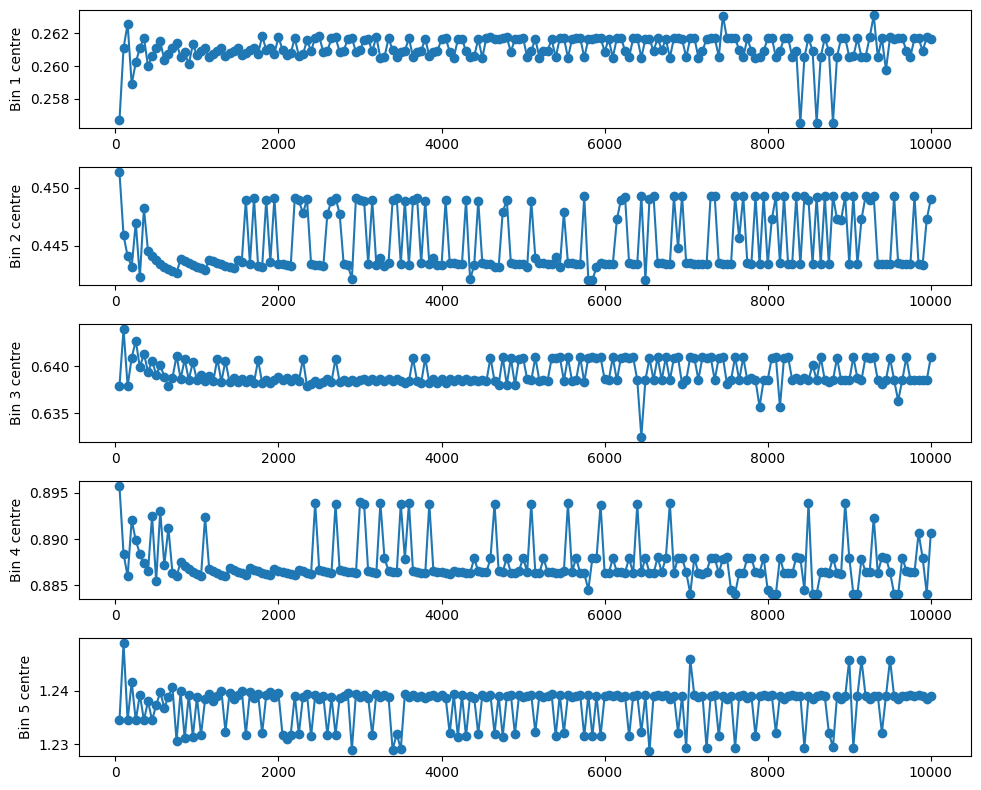

In [111]:
fig, axs = plt.subplots(bin.source_params["n_tomo_bins"], 1, figsize=(10, 8))

for bin_number in range(bin.source_params["n_tomo_bins"]):
    axs[bin_number].plot(
        max_values[bin_number - 1][:, 0], max_values[bin_number - 1][:, 1], "o-"
    )
    axs[bin_number].set_ylabel(f"Bin {bin_number+1} centre")

plt.tight_layout()
plt.savefig("./plots_output/source_bin_centers_sweep_realistic_redshifts.pdf")
plt.show()

In [112]:
np.save(
    "./data_output/bin_centers/bin_centers_sources_realistic_redshifts_by_nredshiftbins_range_50_to_10000.npy",
    max_values,
)